**Import Libraries**





In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# --- CONFIGURATION ---
NUM_ROUNDS = 10
NUM_HOSPITALS = 3
NOISE_MULTIPLIER = 0.01  # Simulated Differential Privacy

In [3]:
# --- 1. DATASET: SIMULATING "SPECIALIST" HOSPITALS (Non-IID) ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
def create_non_iid_data(x, y, num_clients):
    # Sort data by labels to create biased distributions for each hospital
    indices = np.argsort(y)
    x_sorted = x[indices]
    y_sorted = y[indices]

    # Split the sorted data into chunks for each hospital
    x_split = np.array_split(x_sorted, num_clients)
    y_split = np.array_split(y_sorted, num_clients)
    return x_split, y_split

hospitals_x, hospitals_y = create_non_iid_data(x_train, y_train, NUM_HOSPITALS)
print(f"✅ Data Prepared: {NUM_HOSPITALS} Hospitals created with biased patient data.")

✅ Data Prepared: 3 Hospitals created with biased patient data.


In [5]:
# --- 2. MODEL ARCHITECTURE ---
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the Global Model and a "Local-Only" baseline for comparison
global_model = create_model()
local_only_model = create_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# --- 3. FEDERATED CORE WITH DIFFERENTIAL PRIVACY ---
def federated_aggregate(model_list):
    new_weights = []
    layer_count = len(model_list[0].get_weights())

    for l in range(layer_count):
        # Calculate Average
        layer_weights = np.array([m.get_weights()[l] for m in model_list])
        avg_weight = np.mean(layer_weights, axis=0)

        # ADD DIFFERENTIAL PRIVACY: Inject small random noise
        noise = np.random.normal(0, NOISE_MULTIPLIER, avg_weight.shape)
        new_weights.append(avg_weight + noise)

    return new_weights


In [7]:
# --- 4. THE TRAINING LOOP ---
federated_history = []
local_history = []

print("\n Starting Privacy-Preserving Collaboration...\n")

for r in range(NUM_ROUNDS):
    local_models = []

    # Each Hospital trains on its own data
    for i in range(NUM_HOSPITALS):
        # Federated Path
        m = create_model()
        m.set_weights(global_model.get_weights())
        m.fit(hospitals_x[i], hospitals_y[i], epochs=1, batch_size=32, verbose=0)
        local_models.append(m)

        # Local-Only Path (Hospital 1 only, for comparison)
        if i == 0:
            local_only_model.fit(hospitals_x[0], hospitals_y[0], epochs=1, verbose=0)

    # Global Server Aggregates Updates
    new_global_weights = federated_aggregate(local_models)
    global_model.set_weights(new_global_weights)

    # Record Progress
    fed_acc = global_model.evaluate(x_test, y_test, verbose=0)[1]
    loc_acc = local_only_model.evaluate(x_test, y_test, verbose=0)[1]
    federated_history.append(fed_acc)
    local_history.append(loc_acc)

    print(f"Round {r+1}/{NUM_ROUNDS} | Fed Accuracy: {fed_acc:.4%} | Local-Only: {loc_acc:.4%}")




 Starting Privacy-Preserving Collaboration...

Round 1/10 | Fed Accuracy: 48.1000% | Local-Only: 40.7300%
Round 2/10 | Fed Accuracy: 70.4400% | Local-Only: 41.2000%
Round 3/10 | Fed Accuracy: 79.8200% | Local-Only: 41.2000%
Round 4/10 | Fed Accuracy: 83.4300% | Local-Only: 41.3700%
Round 5/10 | Fed Accuracy: 90.8600% | Local-Only: 41.4500%
Round 6/10 | Fed Accuracy: 86.9300% | Local-Only: 41.3900%
Round 7/10 | Fed Accuracy: 86.7900% | Local-Only: 41.4100%
Round 8/10 | Fed Accuracy: 86.5000% | Local-Only: 41.4300%
Round 9/10 | Fed Accuracy: 89.8000% | Local-Only: 41.2600%
Round 10/10 | Fed Accuracy: 90.3000% | Local-Only: 41.4300%


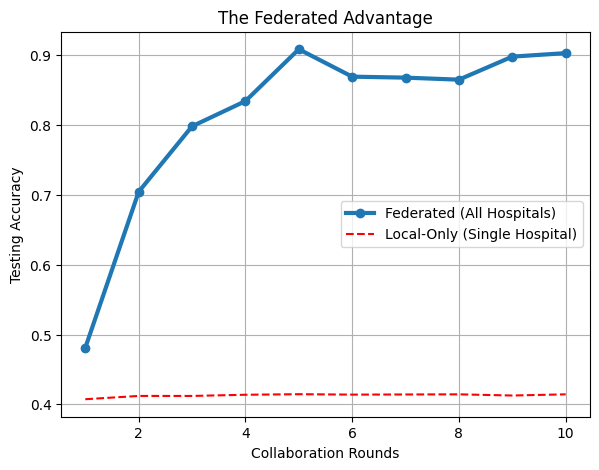

In [8]:
# --- 5. FINAL ANALYTICS & VISUALIZATION ---
plt.figure(figsize=(15, 5))

# Plot 1: The Power of Collaboration
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS+1), federated_history, label='Federated (All Hospitals)', marker='o', linewidth=3)
plt.plot(range(1, NUM_ROUNDS+1), local_history, label='Local-Only (Single Hospital)', linestyle='--', color='red')
plt.title("The Federated Advantage")
plt.xlabel("Collaboration Rounds")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.grid(True)


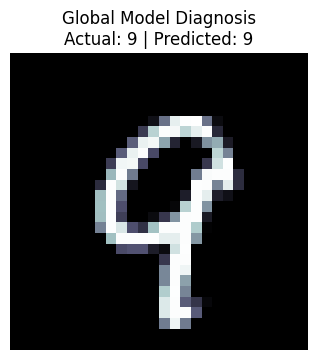


 Conclusion: The Federated model outperforms the Local-only model because
it learned patterns from all hospitals without ever seeing their raw data.


In [9]:
# Plot 2: Diagnosis Visualizer
plt.subplot(1, 2, 2)
sample_idx = np.random.randint(0, len(x_test))
pred = global_model.predict(x_test[sample_idx:sample_idx+1], verbose=0)
plt.imshow(x_test[sample_idx].reshape(28,28), cmap='bone')
plt.title(f"Global Model Diagnosis\nActual: {y_test[sample_idx]} | Predicted: {np.argmax(pred)}")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n Conclusion: The Federated model outperforms the Local-only model because")
print("it learned patterns from all hospitals without ever seeing their raw data.")

**Define the Malicious Hospital**

In [10]:
def malicious_hacker_update(model):
    """
    Simulates a 'Sign-Flipping' attack.
    The hacker takes the real weights and flips their signs to sabotage the global model.
    """
    real_weights = model.get_weights()
    poisoned_weights = [ -1.0 * w for w in real_weights ] # Sabotage!
    return poisoned_weights

**Implement the "Robust Aggregator" (The Defense)**

In [11]:
def robust_federated_aggregate(weight_list):
    """
    A Secure Aggregator.
    Uses np.median instead of np.mean to filter out malicious outliers.
    """
    new_weights = []
    layers = len(weight_list[0])

    for l in range(layers):
        # Stack all hospital updates for this layer
        layer_updates = np.array([w[l] for w in weight_list])
        # Use MEDIAN to find the 'honest' consensus
        robust_update = np.median(layer_updates, axis=0)
        new_weights.append(robust_update)

    return new_weights

**The "Attack vs. Defense" Training Loop**

🚨 Warning: Malicious Client detected in the network!
Round 1 | Standard (Vulnerable): 31.42% | Robust (Secure): 28.21%
Round 2 | Standard (Vulnerable): 55.44% | Robust (Secure): 54.44%
Round 3 | Standard (Vulnerable): 67.89% | Robust (Secure): 68.45%
Round 4 | Standard (Vulnerable): 81.85% | Robust (Secure): 82.76%
Round 5 | Standard (Vulnerable): 77.86% | Robust (Secure): 87.71%


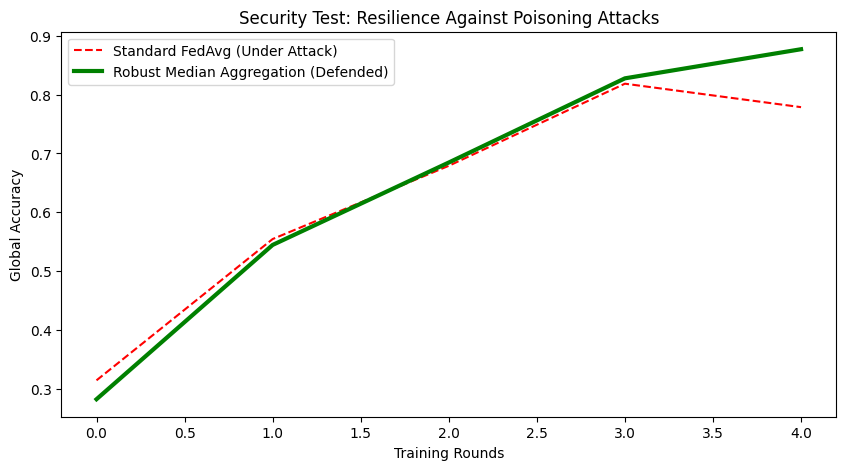

In [12]:
# Initialize two models to compare
standard_model = create_model() # Vulnerable to attack
secure_model = create_model()   # Defended with Robust Aggregation

# Tracking accuracy
standard_acc_history = []
secure_acc_history = []

print("🚨 Warning: Malicious Client detected in the network!")

for r in range(5):
    updates = []

    # 1. Honest Hospitals (Hospitals 1, 2, 3)
    for i in range(3):
        m = create_model()
        m.set_weights(secure_model.get_weights())
        m.fit(hospitals_x[i], hospitals_y[i], epochs=1, verbose=0)
        updates.append(m.get_weights())

    # 2. MALICIOUS HOSPITAL (Hacker)
    hacker_model = create_model()
    hacker_weights = malicious_hacker_update(hacker_model)
    updates.append(hacker_weights) # Hacker joins the party

    # --- THE COMPARISON ---
    # Path A: Standard FedAvg (Fails)
    poisoned_weights = [np.mean(np.array([u[l] for u in updates]), axis=0) for l in range(len(updates[0]))]
    standard_model.set_weights(poisoned_weights)

    # Path B: Robust Aggregation (Succeeds)
    defended_weights = robust_federated_aggregate(updates)
    secure_model.set_weights(defended_weights)

    # Evaluate
    s_acc = standard_model.evaluate(x_test, y_test, verbose=0)[1]
    r_acc = secure_model.evaluate(x_test, y_test, verbose=0)[1]

    standard_acc_history.append(s_acc)
    secure_acc_history.append(r_acc)

    print(f"Round {r+1} | Standard (Vulnerable): {s_acc:.2%} | Robust (Secure): {r_acc:.2%}")

# --- Final Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(standard_acc_history, label='Standard FedAvg (Under Attack)', color='red', linestyle='--')
plt.plot(secure_acc_history, label='Robust Median Aggregation (Defended)', color='green', linewidth=3)
plt.title("Security Test: Resilience Against Poisoning Attacks")
plt.ylabel("Global Accuracy")
plt.xlabel("Training Rounds")
plt.legend()
plt.show()